In [16]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *
from matplotlib import pyplot

In [277]:
file_path = '../Features/rabbit_b_corrvar.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,BalabanJ,...,fr_para_hydroxylation,fr_phos_acid,fr_piperzine,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_unbrch_alkane,fr_urea,Irritation
0,0.115475,0.324234,0.566473,0.398167,0.189110,0.050753,0.574868,0.450980,0.452681,0.362546,...,0.000000,0.0,0,0.0,0.0,0.0,0,0.277350,0.0,1
1,0.437912,0.106913,0.439388,0.384900,0.215185,0.318853,0.684832,0.694989,0.471835,0.426026,...,0.000000,0.0,0,0.0,0.0,0.0,0,0.160128,0.0,1
2,0.837558,0.114306,0.333101,0.487005,0.558408,0.372708,0.627533,0.507776,0.868672,0.276277,...,0.000000,0.0,0,0.0,0.0,0.0,0,0.000000,0.0,0
3,0.763428,0.052517,0.966983,0.515347,0.432265,0.327673,0.683098,0.529412,0.710703,0.305728,...,0.353553,0.0,0,0.0,0.0,0.0,0,0.000000,0.0,0
4,0.603491,0.132058,0.898095,0.495430,0.476004,0.336422,0.579127,0.555556,0.656392,0.326643,...,0.000000,0.0,0,0.0,0.0,0.0,0,0.000000,1.0,0


In [272]:
file_path = '../Features/Rabbit_B_SHAP.xlsx'
df = pd.read_excel(file_path)
df.head()

,BertzCT,PEOE_VSA1,HallKierAlpha,SlogP_VSA2,MinAbsEStateIndex,EState_VSA4,PEOE_VSA6,EState_VSA3,PEOE_VSA7,BalabanJ,PEOE_VSA9,Irritation
0,0.089220,0.196324,0.511069,0.143961,0.324234,0.238203,0.335060,0.000000,0.282180,0.362546,0.000000,1
1,0.146317,0.178444,0.462893,0.203511,0.106913,0.408654,0.260868,0.232360,0.198575,0.426026,0.230156,1
2,0.496390,0.261267,0.283431,0.241053,0.114306,0.333665,0.349547,0.385749,0.473166,0.276277,0.361580,0
3,0.435679,0.315318,0.295994,0.333288,0.052517,0.000000,0.204384,0.216291,0.267249,0.305728,0.385121,0
4,0.402744,0.189052,0.361936,0.335075,0.132058,0.291480,0.282637,0.290634,0.443630,0.326643,0.205850,0


In [154]:
feature_names = list(df.columns)
feature_names

['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'SlogP_VSA2',
 'MinAbsEStateIndex',
 'EState_VSA4',
 'PEOE_VSA6',
 'EState_VSA3',
 'PEOE_VSA7',
 'BalabanJ',
 'PEOE_VSA9',
 'Irritation']

In [63]:
with open('feature_names.txt', 'w') as f:
    for line in feature_names:
        f.write(f"{line}\n")

In [278]:

X = df.drop(columns=['Irritation']) 
y = df['Irritation']

In [334]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)


print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Train set: 582 samples
Validation set: 103 samples
Test set: 172 samples


In [362]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

# Define the objective function for Optuna with cross-validation
def objective(trial):
    # Define the hyperparameter space
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 5),  
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, step=0.005),  
        'n_estimators': trial.suggest_int('n_estimators', 70, 110),  
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 20), 
        'gamma': trial.suggest_float('gamma', 0.5, 2.0), 
        'subsample': trial.suggest_float('subsample', 0.55, 0.75), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.75, 0.85),  
        'lambda': trial.suggest_float('lambda', 20, 40),  
        'alpha': trial.suggest_float('alpha', 2, 20),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 40),  
    }

    # Create an XGBoost classifier with the suggested parameters
    model = xgb.XGBClassifier(**params)

    # Using Stratified KFold to split data
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    # List to hold cross-validation results
    scores = []

    # Cross-validation with early stopping manually handled
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]  
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        # Fit the model on the training fold and validate with early stopping
        model.fit(X_train_cv, y_train_cv, 
                  eval_set=[(X_valid_cv, y_valid_cv)], 
                  verbose=False)
        
        # Get the accuracy for this fold
        y_pred_fold = model.predict(X_valid_cv)
        accuracy = accuracy_score(y_valid_cv, y_pred_fold)

        #y_pred_prob = model.predict_proba(X_valid_cv)[:, 1]
        #accuracy = roc_auc_score(y_valid_cv, y_pred_prob)
        scores.append(accuracy)
    
    # Return the mean accuracy score across all folds
    return np.mean(scores)

# Create a study and optimize it
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=100)

# Print the best parameters and best score
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

y_pred = best_model.predict(X_train)
final_accuracy = accuracy_score(y_train, y_pred)
print("Final Accuracy on Train Set:", final_accuracy)

y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print("Final Accuracy on Test Set:", final_accuracy)


[I 2025-04-16 09:58:12,079] A new study created in memory with name: no-name-ffed3967-0ba4-46a4-9313-6ce5fb3e1268
[I 2025-04-16 09:58:12,692] Trial 0 finished with value: 0.7749672174141097 and parameters: {'max_depth': 4, 'learning_rate': 0.09999999999999999, 'n_estimators': 80, 'min_child_weight': 10, 'gamma': 0.7796928079657031, 'subsample': 0.6902145075279447, 'colsample_bytree': 0.8261240399750637, 'lambda': 35.587854435771476, 'alpha': 17.95765157558599, 'early_stopping_rounds': 30}. Best is trial 0 with value: 0.7749672174141097.
[I 2025-04-16 09:58:13,205] Trial 1 finished with value: 0.7654209284028324 and parameters: {'max_depth': 5, 'learning_rate': 0.035, 'n_estimators': 103, 'min_child_weight': 10, 'gamma': 0.8122420925865952, 'subsample': 0.595493876437984, 'colsample_bytree': 0.7996573306031696, 'lambda': 35.69092446760514, 'alpha': 8.18712805820767, 'early_stopping_rounds': 38}. Best is trial 0 with value: 0.7749672174141097.
[I 2025-04-16 09:58:13,621] Trial 2 finished

Best parameters: {'max_depth': 5, 'learning_rate': 0.09, 'n_estimators': 103, 'min_child_weight': 8, 'gamma': 0.7340219657762137, 'subsample': 0.6523130917675115, 'colsample_bytree': 0.8019084998446117, 'lambda': 31.7715667874981, 'alpha': 3.747284488273463, 'early_stopping_rounds': 32}
Best score: 0.7993443482821925
Final Accuracy on Train Set: 0.8333333333333334
Final Accuracy on Test Set: 0.8062015503875969


Best parameters: {'max_depth': 6, 'learning_rate': 0.095, 'n_estimators': 87, 'min_child_weight': 11, 'gamma': 1.542338218514812, 'subsample': 0.7002171438108215, 'colsample_bytree': 0.7950838718157917, 'lambda': 30.74219408777457, 'alpha': 4.337951768773651, 'early_stopping_rounds': 33}


/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monika/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/monika/Libra

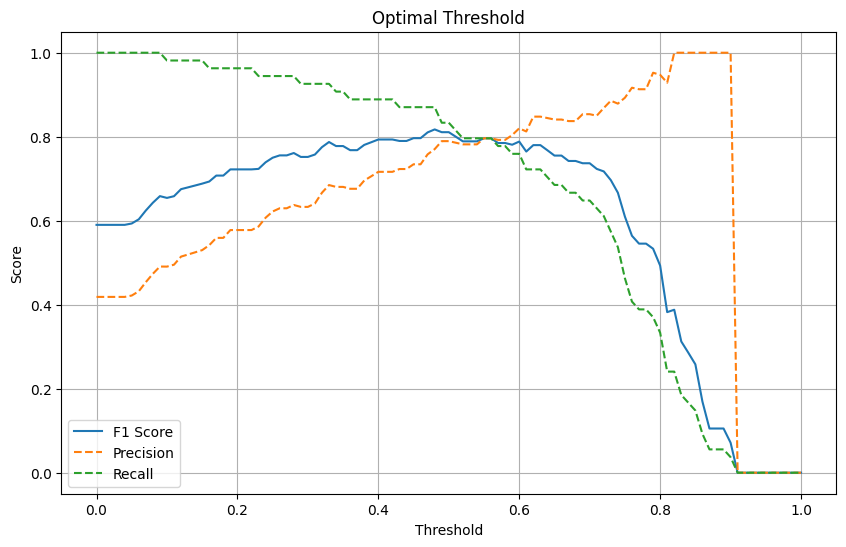

In [341]:
# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

y_proba = final_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Vizualizácia
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()



In [361]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)
best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print()

Train Accuracy: 0.8365695792880259
Test Accuracy: 0.8294573643410853


In [351]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

    best_params = study.best_params


    final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

    final_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],  
        verbose=False
    )

    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8398058252427184 0.811627906976744


In [83]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, learning_curve, validation_curve

Train Accuracy: 0.8187702265372169
Test Accuracy: 0.8062015503875969
Available results keys: dict_keys(['validation_0', 'validation_1'])


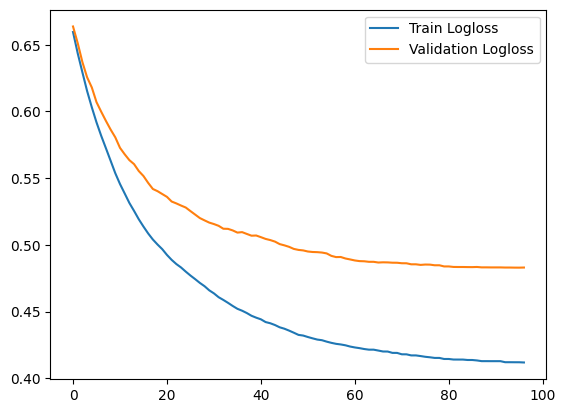

[0]	validation_0-logloss:0.67184
[1]	validation_0-logloss:0.66460
[0]	validation_0-logloss:0.67417
[0]	validation_0-logloss:0.67580
[1]	validation_0-logloss:0.67117
[1]	validation_0-logloss:0.66770
[0]	validation_0-logloss:0.67994
[2]	validation_0-logloss:0.66643
[0]	validation_0-logloss:0.67138
[1]	validation_0-logloss:0.67994
[0]	validation_0-logloss:0.67225
[3]	validation_0-logloss:0.66201
[2]	validation_0-logloss:0.67994
[1]	validation_0-logloss:0.66370
[4]	validation_0-logloss:0.65805
[1]	validation_0-logloss:0.66513
[2]	validation_0-logloss:0.66224
[2]	validation_0-logloss:0.65872
[3]	validation_0-logloss:0.67994
[5]	validation_0-logloss:0.65421
[2]	validation_0-logloss:0.65471
[0]	validation_0-logloss:0.67626
[4]	validation_0-logloss:0.67994
[2]	validation_0-logloss:0.65687
[6]	validation_0-logloss:0.65158
[3]	validation_0-logloss:0.64770
[1]	validation_0-logloss:0.67626
[3]	validation_0-logloss:0.65264
[5]	validation_0-logloss:0.67994
[3]	validation_0-logloss:0.65696
[2]	valida

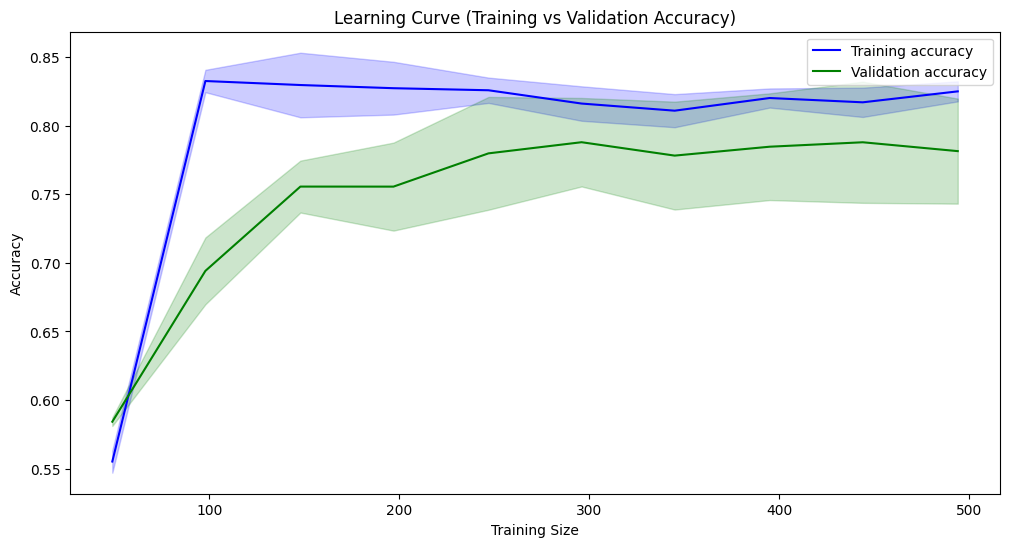

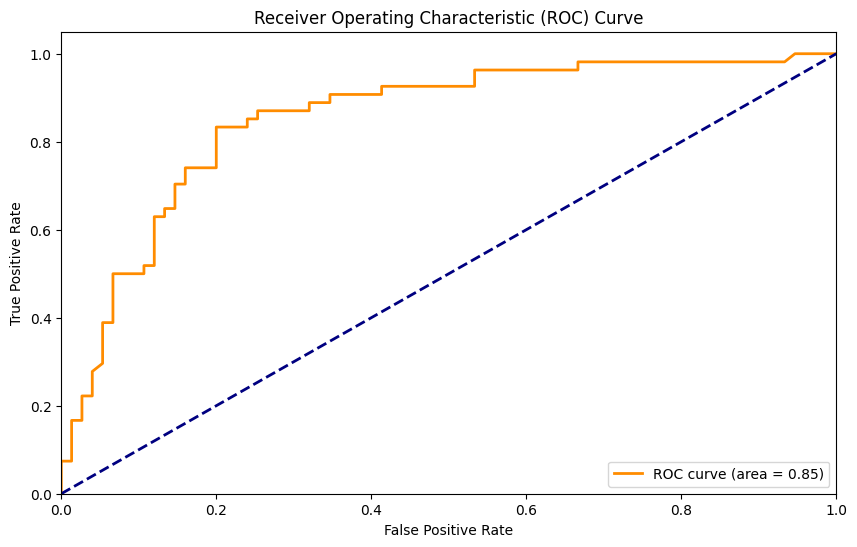

In [327]:

best_params = study.best_params

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


# Get the evaluation results from the training process
results = final_model.evals_result()

# Print the available keys in results to help diagnose the issue
print("Available results keys:", results.keys())

# Check if 'validation_1' exists in the results
if 'validation_1' in results:
    # Plot learning curves for training and validation
    pyplot.plot(results['validation_0']['logloss'], label='Train Logloss')
    pyplot.plot(results['validation_1']['logloss'], label='Validation Logloss')
else:
    print("Validation set logloss not found in the results")

# Show the legend and plot
pyplot.legend()
pyplot.show()

# Learning Curves with Early Stopping
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10),
    fit_params={'eval_set': [(X_valid, y_valid)]}  # Still using validation set for this step
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC-ROC Plot
# Get predicted probabilities for the positive class
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [217]:
# First, split data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# Now, split training data into training (80%) and validation (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

best_params = {
    'max_depth': 4, 
    'learning_rate': 0.055,  
    'n_estimators': 150,  
    'min_child_weight': 4,  
    'gamma': 0.75,  
    'subsample': 0.65, 
    'colsample_bytree': 0.7,  
    'lambda': 8, 
    'alpha': 4,  
    'early_stopping_rounds': 87,
}
#best_params = study.best_params
# best_params = {'booster': 'dart', 'lambda': 6.109101796965115, 'alpha': 2.1542301910444617, 'learning_rate': 0.15828508410665312, 'n_estimators': 200, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0015829960103862651, 'subsample': 0.6335396537951385, 'colsample_bytree': 0.562796436427881, 'early_stopping_rounds': 45}

# Initialize the model with best parameters
final_model = xgb.XGBClassifier(**best_params, eval_metric='logloss', use_label_encoder=False)

# Fit the model with early stopping using the validation set
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],  # Including both train and validation for evaluation
    verbose=False
)

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train set: 618 samples
Validation set: 110 samples
Test set: 129 samples
Train Accuracy: 0.8333333333333334
Test Accuracy: 0.8062015503875969


In [20]:
import shap

In [89]:
import shap

In [25]:
explainer = shap.Explainer(final_model)
shap_values = explainer.shap_values(X_train)


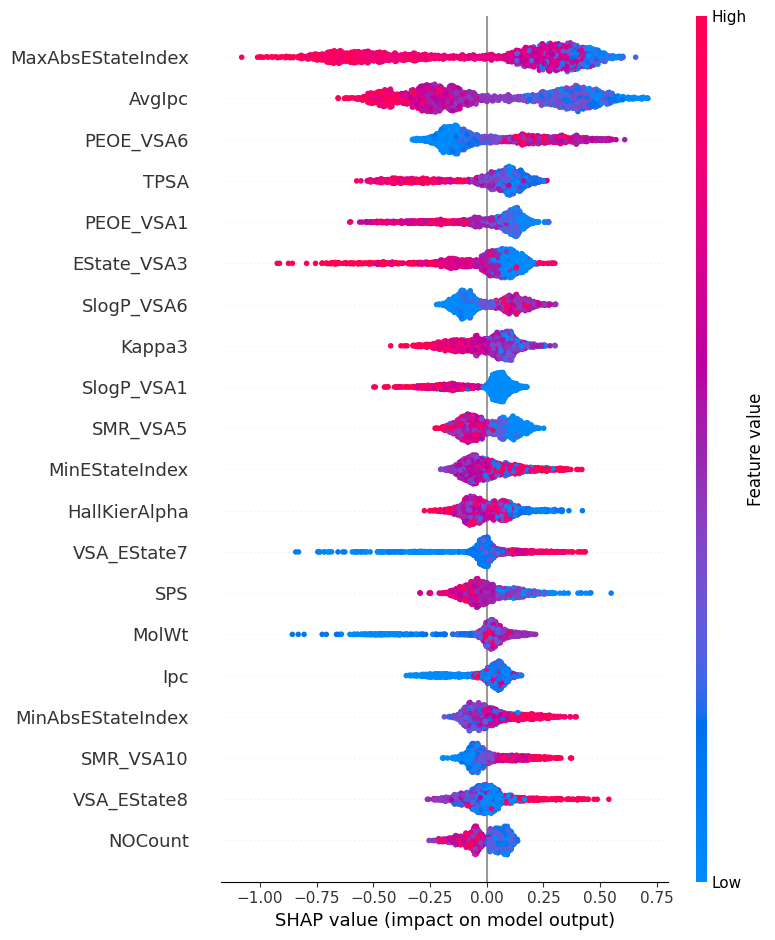

In [26]:
shap.summary_plot(shap_values, X_train)

In [88]:
import joblib

# Assuming 'model' is your trained QSAR model
joblib.dump(final_model, 'xgb_model.pkl')

print("Model saved successfully!")


Model saved successfully!


In [218]:
XGB_features = ['BertzCT',
 'PEOE_VSA1',
 'HallKierAlpha',
 'SlogP_VSA2',
 'MinAbsEStateIndex',
 'EState_VSA4',
 'PEOE_VSA6',
 'EState_VSA3',
 'PEOE_VSA7',
 'BalabanJ',
 'PEOE_VSA9']

In [219]:

def calculate_descriptors(smiles, descriptor_names):

    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:

        descriptor_values = {'SMILES': smiles}
        
        for descriptor_name in descriptor_names:
            if hasattr(Descriptors, descriptor_name):
                descriptor_function = getattr(Descriptors, descriptor_name)
                descriptor_values[descriptor_name] = descriptor_function(mol)
            else:
                print(f"Deskriptor '{descriptor_name}' neexistuje.")
                descriptor_values[descriptor_name] = None
        
        return pd.DataFrame([descriptor_values])
    else:
        print(f"Neplatný SMILES: {smiles}")
        # Ak je SMILES neplatný, vrátime DataFrame s None hodnotami
        descriptor_values = {'SMILES': smiles}
        for descriptor_name in descriptor_names:
            descriptor_values[descriptor_name] = None
        return pd.DataFrame([descriptor_values])

In [232]:
smiles = 'CCN'  

# Výpočet deskriptorov a vrátenie DataFrame
df_descriptors = calculate_descriptors(smiles, XGB_features)

In [225]:
df_descriptors

,SMILES,BertzCT,PEOE_VSA1,HallKierAlpha,SlogP_VSA2,MinAbsEStateIndex,EState_VSA4,PEOE_VSA6,EState_VSA3,PEOE_VSA7,BalabanJ,PEOE_VSA9
0,NCO,4.754888,10.840195,-0.08,11.837344,0.25,0.0,0.0,0.0,0.0,1.632993,6.730817


In [233]:
final_model.predict(df_descriptors.drop(columns="SMILES"))[0]

0

In [101]:
descriptors = list(X.columns)
descriptors

['MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'MaxPartialCharge',
 'MinPartialCharge',
 'FpDensityMorgan1',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'HallKierAlpha',
 'Kappa2',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA5',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'TPSA',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'VSA_EState1',
 'VSA_EState2',
 'VSA_EState3',
 'VSA_EState4',
 'VSA_EState6',
 'VSA_EState7',
 'VSA_EState8',
 'FractionCSP3',
 'NHOHCount',
 'NumAliphaticCar

In [107]:
file_path = '../Datasets/rabbit_names.xlsx'
names = pd.read_excel(file_path)

In [112]:
names.index

RangeIndex(start=0, stop=1338, step=1)

In [113]:
X.index

RangeIndex(start=0, stop=1780, step=1)

In [134]:
new = df.join(names)

In [135]:
# Step 2: Predict using the trained model
predictions = final_model.predict(df.drop(columns="Irritation"))

# Step 3: Add predictions as a new column
new['Pred'] = predictions
new

,Irritation,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,AvgIpc,...,fr_para_hydroxylation,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_unbrch_alkane,fr_urea,Name,CAS RN,SMILES,Pred
0,1,0.380977,0.301948,0.403803,0.385193,0.187251,0.199575,0.550820,0.588235,0.452681,...,0.000000,0.0,0.0,0.0,0.277350,0.0,JP_CHRIP:\np-Nitrochlorobenzene,100-00-5,O=[N+]([O-])c1ccc(Cl)cc1,1
1,1,0.443959,0.118847,0.725612,0.470253,0.326442,0.202175,0.550534,0.560784,0.542612,...,0.000000,0.0,0.0,0.0,0.000000,0.0,EU_REACH:\nbutyl N-[(butylsulfanyl)methanethio...,1001320-38-2,CCCCOC(=O)NC(=S)SCCCC,1
2,1,0.049599,0.376730,0.440935,0.382546,0.249141,0.032276,0.304644,0.633987,0.404010,...,0.000000,0.0,0.0,0.0,0.160128,0.0,"EU_REACH:\n(1S,3R,5R,6S,8R,10R,11S,13R,15R,16S...",10016-20-3,OC[C@H]1O[C@@H]2O[C@H]3[C@H](O)[C@@H](O)[C@@H]...,1
3,1,0.297132,0.200094,0.634828,0.454915,0.257268,0.120148,0.629576,0.650624,0.467685,...,0.000000,0.0,0.0,0.0,0.000000,0.0,EU_REACH:\n1-butoxy-4-[4-(trans-4-ethylcyclohe...,1003218-33-4,CCCCOc1ccc(C2=CCC(C3CCC(CC)CC3)CC2)c(F)c1F,1
4,1,0.067411,0.305414,0.501957,0.647698,0.225299,0.075490,0.315990,0.835294,0.471625,...,0.000000,0.0,0.0,0.0,0.000000,0.0,"EU_REACH:\n4-methyl-1,3-oxazole-5-carbonitrile",1003-52-7,Cc1ncoc1C#N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,0,0.571631,0.005535,0.227153,0.462282,0.549057,0.320676,0.680453,0.235294,0.675689,...,0.000000,0.0,0.0,0.0,0.423659,0.0,NaN,NaN,NaN,0
1776,0,0.710245,0.103080,0.709590,0.401685,0.326550,0.404594,0.701528,0.704374,0.510334,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,0
1777,0,0.612208,0.055253,0.911328,0.422921,0.432362,0.262104,0.712717,0.450980,0.615202,...,0.000000,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,0
1778,0,0.580291,0.119213,0.720249,0.400203,0.411566,0.322078,0.700097,0.560784,0.618318,...,0.353553,0.0,0.0,0.0,0.000000,0.0,NaN,NaN,NaN,0


In [ ]:
i = 1

In [143]:
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import numpy as np

atom_based_descriptor_prefixes = [
    'PEOE_VSA', 'SMR_VSA', 'SlogP_VSA', 'EState_VSA', 'VSA_EState'
]

def get_descriptor_type(descriptor_name):
    for prefix in atom_based_descriptor_prefixes:
        if descriptor_name.startswith(prefix):
            return prefix
    return None

def get_atom_contributions(mol, descriptor_name):
    if descriptor_name.startswith("PEOE_VSA"):
        contribs, _ = rdMolDescriptors.GetPEOEVSAContribs(mol)
        return np.array(contribs)
    elif descriptor_name.startswith("SlogP_VSA"):
        contribs, _ = rdMolDescriptors.GetSlogPVSAContribs(mol)
        return np.array(contribs)
    elif descriptor_name.startswith("SMR_VSA"):
        contribs, _ = rdMolDescriptors.GetSMRVSAContribs(mol)
        return np.array(contribs)
    elif descriptor_name.startswith("EState_VSA"):
        contribs, _ = rdMolDescriptors.GetEstateVSAContribs(mol)
        return np.array(contribs)
    elif descriptor_name.startswith("VSA_EState"):
        contribs, _ = rdMolDescriptors.GetVSAEstateIndices(mol)
        return np.array(contribs, dtype=float)
    return None

def calculate_atom_importance_from_shap(smiles, descriptor_names, shap_values_for_mol):
    mol = Chem.MolFromSmiles(smiles)
    num_atoms = mol.GetNumAtoms()
    atom_scores = np.zeros(num_atoms)

    for i, descriptor_name in enumerate(descriptor_names):
        descriptor_type = get_descriptor_type(descriptor_name)
        if descriptor_type:
            atom_contribs = get_atom_contributions(mol, descriptor_name)
            if atom_contribs is not None:
                total = np.sum(np.abs(atom_contribs))
                if total == 0:
                    continue
                atom_contribs = atom_contribs / total
                atom_scores += shap_values_for_mol[i] * atom_contribs

    return atom_scores.tolist()


In [137]:
import shap

explainer = shap.Explainer(final_model, X)  # X is your descriptor feature set
shap_values = explainer(X)


In [145]:
i = 0  # or any row you're processing
smiles = new.iloc[i]['SMILES']
shap_scores = shap_values[i].values
descriptor_names = list(X.columns)

atom_scores = calculate_atom_importance_from_shap(smiles, descriptor_names, shap_scores)


AttributeError: module 'rdkit.Chem.rdMolDescriptors' has no attribute 'GetPEOEVSAContribs'

In [130]:
def descriptor_to_smiles_scores(shap_scores, smiles):
    score_scalar = np.mean(np.abs(shap_scores))
    return [score_scalar] * len(smiles)


In [131]:
import shap
import json
import numpy as np
import xsmiles

# Get SHAP values for your model
explainer = shap.Explainer(final_model, X)
shap_values = explainer(X)

def descriptor_to_smiles_scores(shap_scores, smiles):
    # ⚠️ Simple hack: just average importance and duplicate over smiles length
    # Better: use token-importance mapping (optional, more complex)
    score_scalar = np.mean(np.abs(shap_scores))
    return [score_scalar] * len(smiles)

molecules = []

for i, row in new.iterrows():
    smiles = row['SMILES']
    pred = row['Pred']
    truth = row['qed']
    name = row.get('Name', f"Mol_{i}")

    # Get SHAP scores for this molecule
    shap_scores = shap_values[i].values.tolist()

    # Map descriptor-level SHAP scores to SMILES-level visualization
    scores = descriptor_to_smiles_scores(shap_scores, smiles)

    molecule = {
        'string': smiles,
        'methods': [{
            'name': 'SHAP-based Importance',
            'scores': scores,
            'attributes': {
                'Pred.': float(pred)
            }
        }],
        'attributes': {
            'Truth': float(truth),
            'Name': name
        }
    }
    molecules.append(molecule)

# Show in XSMILES widget
xsmiles.XSmilesWidget(molecules=json.dumps(molecules))


TypeError: object of type 'float' has no len()

In [115]:
import xsmiles
import json

In [116]:
print("XSMILES-JupyterLab version:", xsmiles.__version__) 

XSMILES-JupyterLab version: 0.2.2


In [117]:
small_molecule = {
        'string': "CN=C=O",
        'methods': [
            { 'name': "method 1", 'scores': [0.0, 0.25, 0.0, -0.5], 'attributes':{'Pred.':0.55} }, # scores.length == N of atom characters (here, CNCO)
            { 'name': "method 2", 'scores': [0.05, 0.25, 0.3, 0.15, -0.15, -0.3],'attributes':{'Pred.':0.66} }, # scores.length == string.length
        ],
        'attributes': {"Truth": 0.6} # 'attributes' is mandatory in the current version. Please use an empty object if you won't add attributes: 'attributes':{}
    }

xsmiles.XSmilesWidget(molecules=json.dumps([small_molecule])) # create xsmiles object

XSmilesWidget(molecules='[{"string": "CN=C=O", "methods": [{"name": "method 1", "scores": [0.0, 0.25, 0.0, -0.…